# Benchmark Analysis - H4

In [180]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [181]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [182]:
matplotlib.style.use('seaborn-v0_8')  

In [183]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M'

In [184]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [185]:
plot_save_dir = './plots/h4'

## Utils 

In [186]:
def get_path(*entries):
    return os.path.join(*entries)

In [187]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [188]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"))
    plt.show()

In [189]:
def extraction_pandas_frame_algo(path, COMP="TODO"):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [190]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [191]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [192]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

# H4
> Different compilers/backends may fallback to sequential algorithms, leading to better performance.

## `b4_1_merge_cutoff_wrapper_par`

### Time Comparison - `b4_1_merge_cutoff_wrapper_par`


Check how the runtime without constraining the threads develops with increasing input size

In [193]:
def get_b4_1_merge_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_1_merge_cutoff_wrapper_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_1_merge_cutoff_wrapper_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_1_merge_data_algo(*x) for x in instances]


# merge for plotting 
b4_1_merge_time_merged = pd.merge(*data, on='n')

b4_1_merge_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.250660e+02,4,14704.5
1,3.241600e+02,8,11680.9
2,3.457330e+02,16,11605.0
3,3.593830e+02,32,12331.7
4,3.979230e+02,64,12370.4
5,4.785570e+02,128,13856.8
6,7.072550e+02,256,13862.0
7,1.019470e+03,512,13786.6
8,1.285850e+04,1024,15094.5
9,1.585280e+04,2048,17508.4


### Strong Scaling - `b4_1_merge_cutoff_wrapper_par`
 
1 Million fixed input size with threads 1-64

In [194]:
def get_b4_1_merge_cutoff_wrapper_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_1_merge_cutoff_wrapper_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## b4_1_merge_cutoff_wrapper_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_1_merge_cutoff_wrapper_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                            )
    
    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_1_merge_cutoff_wrapper_scaling_algo(*x) for x in instances]

b4_1_merge_cutoff_wrapper_strong_scaling_merged = pd.merge(*data, on='threads')


b4_1_merge_cutoff_wrapper_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.793193,0.565099
1,2,1.052599,0.742663
2,4,1.211125,0.867781
3,8,1.177090,0.911062
4,16,1.182160,0.885392
5,32,0.943842,0.874202
6,64,1.134067,0.852849


In [195]:
# efficiency b4_4_set_difference_cutoff_intersected_par
b4_1_merge_cutoff_wrapper_efficiency = b4_1_merge_cutoff_wrapper_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_1_merge_cutoff_wrapper_efficiency[f'{compiler_name}'] = b4_1_merge_cutoff_wrapper_efficiency[f'{compiler_name}'] / b4_1_merge_cutoff_wrapper_efficiency['threads']
    

b4_1_merge_cutoff_wrapper_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.793193,0.565099
1,2,0.526300,0.371331
2,4,0.302781,0.216945
3,8,0.147136,0.113883
4,16,0.073885,0.055337
5,32,0.029495,0.027319
6,64,0.017720,0.013326


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_79168/4172653622.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


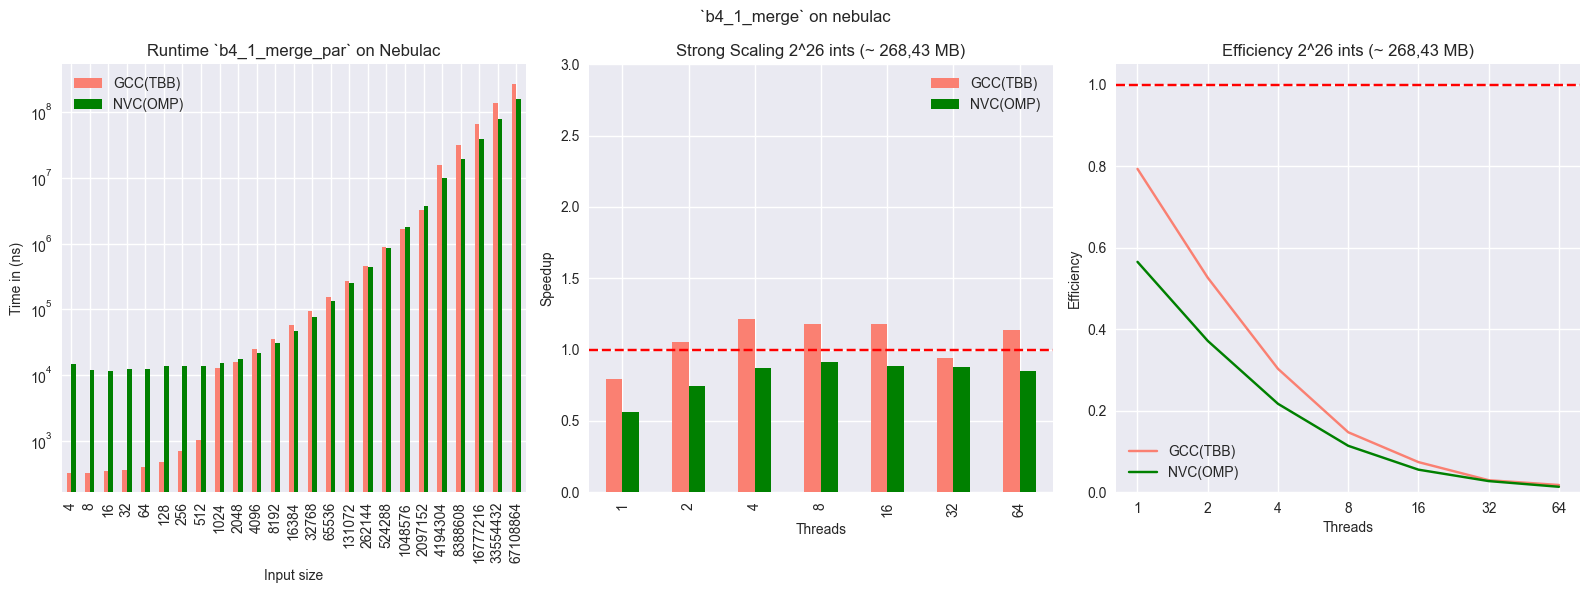

In [196]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b4_1_merge_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Input size')
ax_1.set_title('Runtime `b4_1_merge_par` on Nebulac')



# plot strong scaling
ax_2 = b4_1_merge_cutoff_wrapper_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b4_1_merge_cutoff_wrapper_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                             ax=axes[2]
                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')



fig.suptitle("`b4_1_merge` on nebulac")

fig.tight_layout()

plot("`b4_1_merge` nebulac")

## `b4_2_stable_sort`


### Time Comparison - `b4_2_stable_sort_cutoff_already_sorted_par`

Check how the runtime without constraining the threads develops with increasing input size

In [197]:
def get_b4_2_stable_sort_cutoff_already_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_already_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_already_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_already_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_already_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_already_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.520890e+02,4,53843.1
1,3.634050e+02,8,39293.9
2,4.271840e+02,16,48216.4
3,4.984580e+02,32,58476.8
4,7.050570e+02,64,68444.3
5,1.031590e+03,128,69433.2
6,1.755100e+03,256,68057.5
7,1.123420e+04,512,68734.2
8,2.159870e+04,1024,70339.1
9,2.704730e+04,2048,73455.3


### Time Comparison - `b4_2_stable_sort_cutoff_decrement_sorted_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [198]:
def b4_2_stable_sort_cutoff_decrement_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_decrement_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_2_stable_sort_cutoff_decrement_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_decrement_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_decrement_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.506510e+02,4,41904.3
1,3.589990e+02,8,43018.2
2,4.130830e+02,16,52062.8
3,5.013130e+02,32,61406.9
4,6.933680e+02,64,73260.9
5,1.026730e+03,128,73169.7
6,1.701030e+03,256,72195.0
7,1.265950e+04,512,73391.9
8,2.105450e+04,1024,72692.9
9,2.621500e+04,2048,77920.9


### Time Comparison - `b4_2_stable_sort_cutoff_not_sorted_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [199]:
def b4_2_stable_sort_cutoff_not_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_not_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_not_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_2_stable_sort_cutoff_not_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_not_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_not_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.484690e+02,4,36865.2
1,3.558530e+02,8,42663.1
2,4.265220e+02,16,51210.8
3,4.973340e+02,32,61412.5
4,7.308890e+02,64,69713.1
5,1.060610e+03,128,67883.9
6,1.817800e+03,256,83150.9
7,1.567650e+04,512,78079.9
8,1.754950e+04,1024,70089.9
9,2.323670e+04,2048,73426.2


### Strong Scaling - `b4_2_stable_sort_cutoff_already_sorted_par`

In [200]:
def get_b4_2_stable_sort_cutoff_already_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_already_sorted_seq__Default.csv',
                                            COMP=compiler_name)
    
    
    ## b4_2_stable_sort_cutoff_already_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_already_sorted_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                            )
    
    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_already_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,2.759531,0.066580
1,2,5.430490,0.128499
2,4,10.523804,0.249164
3,8,19.238297,0.493901
4,16,38.811504,0.825348
5,32,48.460165,1.086284
6,64,46.653527,1.347642


In [201]:
# efficiency b4_2_stable_sort_cutoff_already_sorted_par
b4_2_stable_sort_cutoff_already_sorted_efficiency = b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_already_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_already_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_already_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_already_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,2.759531,0.066580
1,2,2.715245,0.064249
2,4,2.630951,0.062291
3,8,2.404787,0.061738
4,16,2.425719,0.051584
5,32,1.514380,0.033946
6,64,0.728961,0.021057


### Strong Scaling - `b4_2_stable_sort_cutoff_decrement_sorted_par`

1 Million fixed input size with threads 1-64

In [202]:
def get_b4_2_stable_sort_cutoff_decrement_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_decrement_sorted_seq__Default.csv',
                                            COMP=compiler_name)
    
    
    ## b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_decrement_sorted_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_decrement_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.116568,0.089459
1,2,2.063658,0.172034
2,4,5.901089,0.314606
3,8,16.012185,0.621850
4,16,31.467029,0.998001
5,32,39.682577,1.440806
6,64,37.153543,2.007801


In [203]:
# efficiency b4_2_stable_sort_cutoff_decrement_sorted_par
b4_2_stable_sort_cutoff_decrement_sorted_efficiency = b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_decrement_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_decrement_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_decrement_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_decrement_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.116568,0.089459
1,2,1.031829,0.086017
2,4,1.475272,0.078652
3,8,2.001523,0.077731
4,16,1.966689,0.062375
5,32,1.240081,0.045025
6,64,0.580524,0.031372


### Strong Scaling - `b4_2_stable_sort_cutoff_not_sorted_par`

1 Million fixed input size with threads 1-64

In [204]:
def get_b4_2_stable_sort_cutoff_not_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_not_sorted_seq__Default.csv',
                                            COMP=compiler_name)
    
    
    ## b4_2_stable_sort_cutoff_not_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_not_sorted_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_not_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.968474,3.259110
1,2,1.877559,4.398877
2,4,3.635517,5.154489
3,8,6.325085,5.490621
4,16,47.863843,5.404142
5,32,81.219384,4.946492
6,64,163.713328,4.088222


In [205]:
# efficiency b4_2_stable_sort_cutoff_not_sorted_par
b4_2_stable_sort_cutoff_not_sorted_efficiency = b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_not_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_not_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_not_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_not_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.968474,3.259110
1,2,0.938779,2.199439
2,4,0.908879,1.288622
3,8,0.790636,0.686328
4,16,2.991490,0.337759
5,32,2.538106,0.154578
6,64,2.558021,0.063878


### Plotting

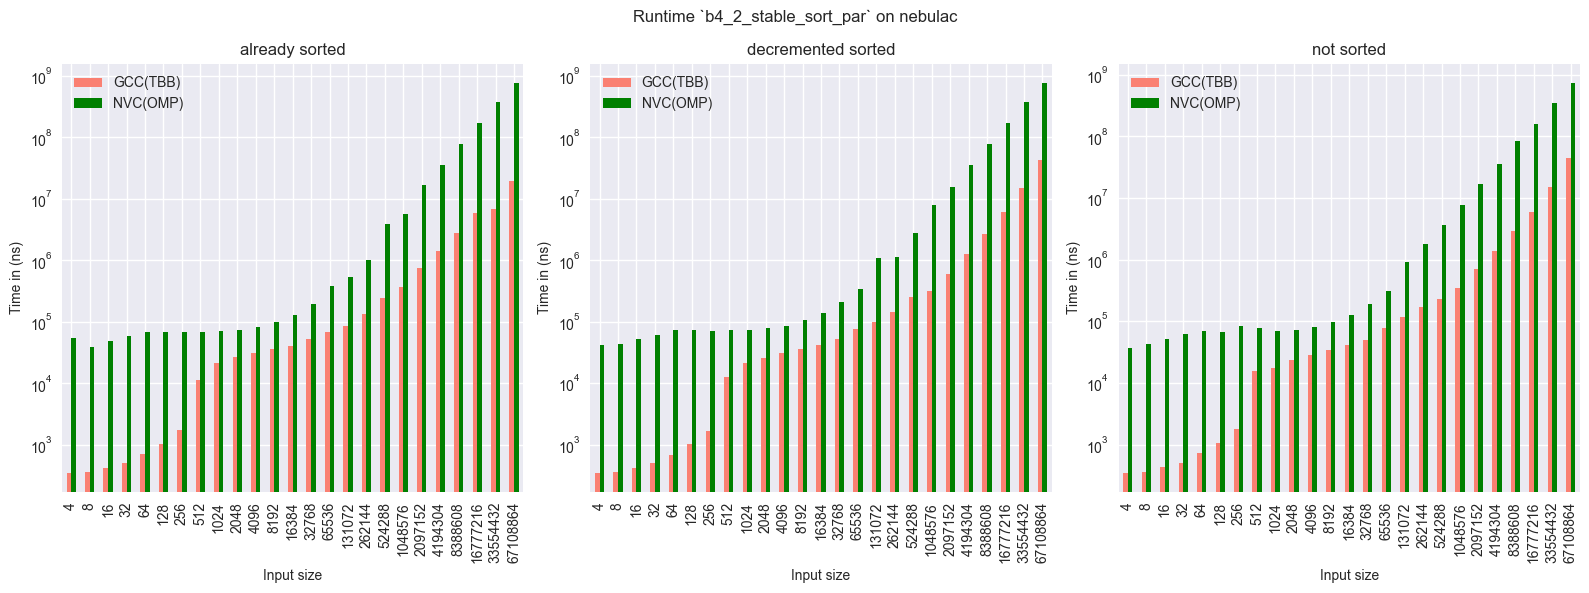

In [206]:
### Runtime

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Input size')
ax_1.set_title('already sorted')


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Input size')
ax_2.set_title('decremented sorted')


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Input size')
ax_3.set_title('not sorted')

fig.suptitle("Runtime `b4_2_stable_sort_par` on nebulac")

fig.tight_layout()

plot("Runtime `b4_2_stable_sort_par` on nebulac")


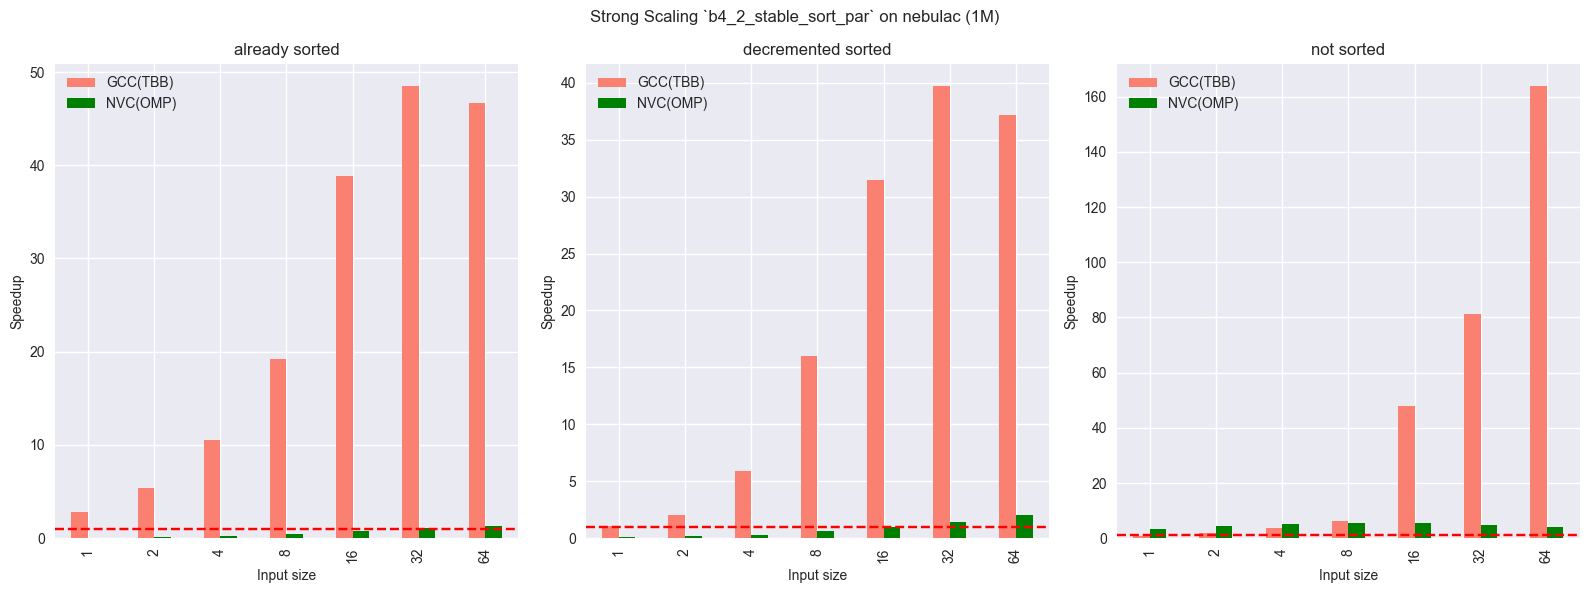

In [207]:
## stable sort strong scaling graphs


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Input size')
ax_1.set_title('already sorted')
ax_1.axhline(y=1,color='r', linestyle='--')


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Input size')
ax_2.set_title('decremented sorted')
ax_2.axhline(y=1,color='r', linestyle='--')


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Input size')
ax_3.set_title('not sorted')
ax_3.axhline(y=1,color='r', linestyle='--')

fig.suptitle("Strong Scaling `b4_2_stable_sort_par` on nebulac (1M)")

fig.tight_layout()

plot("Strong Scaling `b4_2_stable_sort_par` on nebulac (1M)")


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_79168/3198609579.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_79168/3198609579.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_79168/3198609579.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


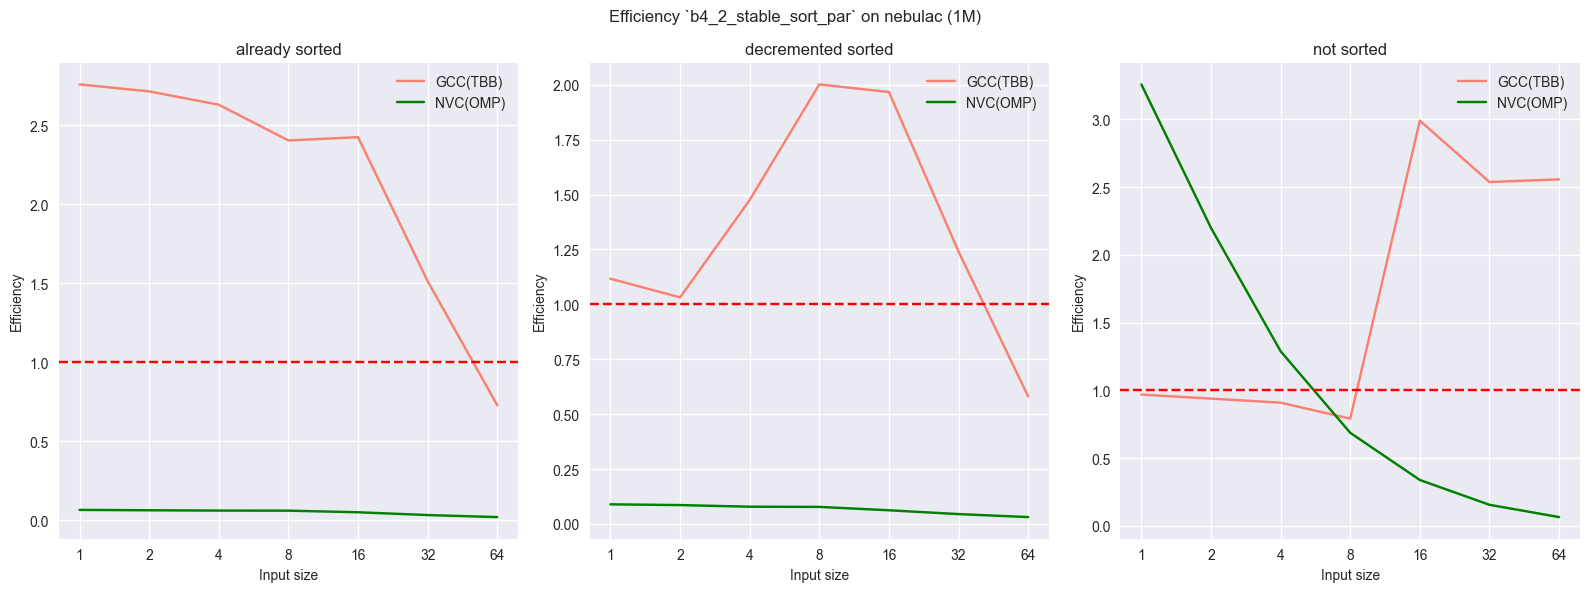

In [208]:
### efficiency stable sort

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Input size')
ax_1.set_title('already sorted')
ax_1.axhline(y=1,color='r', linestyle='--')

#ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Input size')
ax_2.set_title('decremented sorted')
ax_2.axhline(y=1,color='r', linestyle='--')

#ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Input size')
ax_3.set_title('not sorted')
ax_3.axhline(y=1,color='r', linestyle='--')



ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


fig.suptitle("Efficiency `b4_2_stable_sort_par` on nebulac (1M)")

fig.tight_layout()

plot("Efficiency `b4_2_stable_sort_par` on nebulac (1M)")


## `b4_3_set_union`

### Time Comparison - `b4_3_set_union_cutoff_one_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [209]:
def b4_3_set_union_cutoff_one_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_one_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_one_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_one_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_one_empty_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_one_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.141170e+02,4,12556.8
1,3.184330e+02,8,11526.4
2,3.144690e+02,16,11611.2
3,3.133670e+02,32,12674.7
4,3.143500e+02,64,12656.2
5,3.228770e+02,128,12107.0
6,3.462300e+02,256,12048.2
7,4.359090e+02,512,13705.2
8,3.918210e+04,1024,14666.4
9,4.487490e+04,2048,17283.3


### Time Comparison - `b4_3_set_union_cutoff_one_wholly_greater_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [210]:
def b4_3_set_union_cutoff_one_wholly_greater_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_one_wholly_greater_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_one_wholly_greater_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_one_wholly_greater_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_one_wholly_greater_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_one_wholly_greater_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.130240e+02,4,14018.7
1,3.183080e+02,8,10557.0
2,3.314190e+02,16,10607.9
3,3.458380e+02,32,11823.2
4,3.845540e+02,64,13071.6
5,4.403410e+02,128,12290.7
6,6.164470e+02,256,12596.6
7,4.886990e+04,512,13627.4
8,4.968680e+04,1024,13210.2
9,5.763880e+04,2048,17018.9


### Time Comparison - `b4_3_set_union_cutoff_front_overhang_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [211]:
def b4_3_set_union_cutoff_front_overhang_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_front_overhang_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_front_overhang_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_front_overhang_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_front_overhang_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_front_overhang_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.068190e+02,4,12543.8
1,3.088140e+02,8,11399.4
2,3.177700e+02,16,11201.8
3,3.502540e+02,32,12480.0
4,3.903390e+02,64,13174.3
5,4.887050e+02,128,13286.5
6,6.968400e+02,256,13750.3
7,1.240210e+05,512,13538.8
8,1.031810e+05,1024,14378.2
9,1.084390e+05,2048,16101.4


### Strong Scaling - `b4_3_set_union_cutoff_one_empty_par`

1 Million fixed input size with threads 1-64

In [212]:
def get_b4_3_set_union_cutoff_one_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_one_empty_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## b4_3_set_union_cutoff_one_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_one_empty_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_one_empty_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_one_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_one_empty_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.847951,0.227101
1,2,0.930398,0.401083
2,4,0.916601,0.635756
3,8,0.832747,0.743147
4,16,0.835891,0.687488
5,32,0.838545,0.486043
6,64,0.807144,0.671343


In [213]:
# efficiency b4_3_set_union_cutoff_one_empty_par
b4_3_set_union_cutoff_one_empty_efficiency = b4_3_set_union_cutoff_one_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_one_empty_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_one_empty_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_one_empty_efficiency['threads']



b4_3_set_union_cutoff_one_empty_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.847951,0.227101
1,2,0.465199,0.200541
2,4,0.229150,0.158939
3,8,0.104093,0.092893
4,16,0.052243,0.042968
5,32,0.026205,0.015189
6,64,0.012612,0.010490


### Strong Scaling - `b4_3_set_union_cutoff_one_wholly_greater_par`

1 Million fixed input size with threads 1-64

In [214]:
def get_b4_3_set_union_cutoff_one_wholly_greater_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_one_wholly_greater_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## b4_3_set_union_cutoff_one_wholly_greater_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_one_wholly_greater_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_one_wholly_greater_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.056859,0.426311
1,2,1.165557,0.628353
2,4,1.160858,0.805633
3,8,0.991385,0.908864
4,16,1.053929,0.874029
5,32,1.049231,0.363667
6,64,1.031313,0.835248


In [215]:

# efficiency b4_3_set_union_cutoff_one_wholly_greater_par
b4_3_set_union_cutoff_one_wholly_greater_efficiency = b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_one_wholly_greater_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_one_wholly_greater_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_one_wholly_greater_efficiency['threads']



b4_3_set_union_cutoff_one_wholly_greater_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.056859,0.426311
1,2,0.582779,0.314176
2,4,0.290215,0.201408
3,8,0.123923,0.113608
4,16,0.065871,0.054627
5,32,0.032788,0.011365
6,64,0.016114,0.013051


### Strong Scaling - `b4_3_set_union_cutoff_front_overhang_par`

1 Million fixed input size with threads 1-64

In [216]:
def get_b4_3_set_union_cutoff_front_overhang_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_front_overhang_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## b4_3_set_union_cutoff_front_overhang_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_front_overhang_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_front_overhang_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_front_overhang_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_front_overhang_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.766672,0.616866
1,2,0.944437,0.785002
2,4,1.084079,0.872539
3,8,1.086393,0.937672
4,16,1.075273,0.925258
5,32,0.629881,0.880565
6,64,0.955088,0.855976


In [217]:
# efficiency b4_3_set_union_cutoff_front_overhang_par
b4_3_set_union_cutoff_front_overhang_efficiency = b4_3_set_union_cutoff_front_overhang_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_front_overhang_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_front_overhang_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_front_overhang_efficiency['threads']



b4_3_set_union_cutoff_front_overhang_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.766672,0.616866
1,2,0.472219,0.392501
2,4,0.271020,0.218135
3,8,0.135799,0.117209
4,16,0.067205,0.057829
5,32,0.019684,0.027518
6,64,0.014923,0.013375


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_79168/2713382404.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_1.set_ylim(0,y_lim)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_79168/2713382404.py:24: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_2.set_ylim(0,y_lim)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_79168/2713382404.py:34: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_3.set_ylim(0,y_lim)


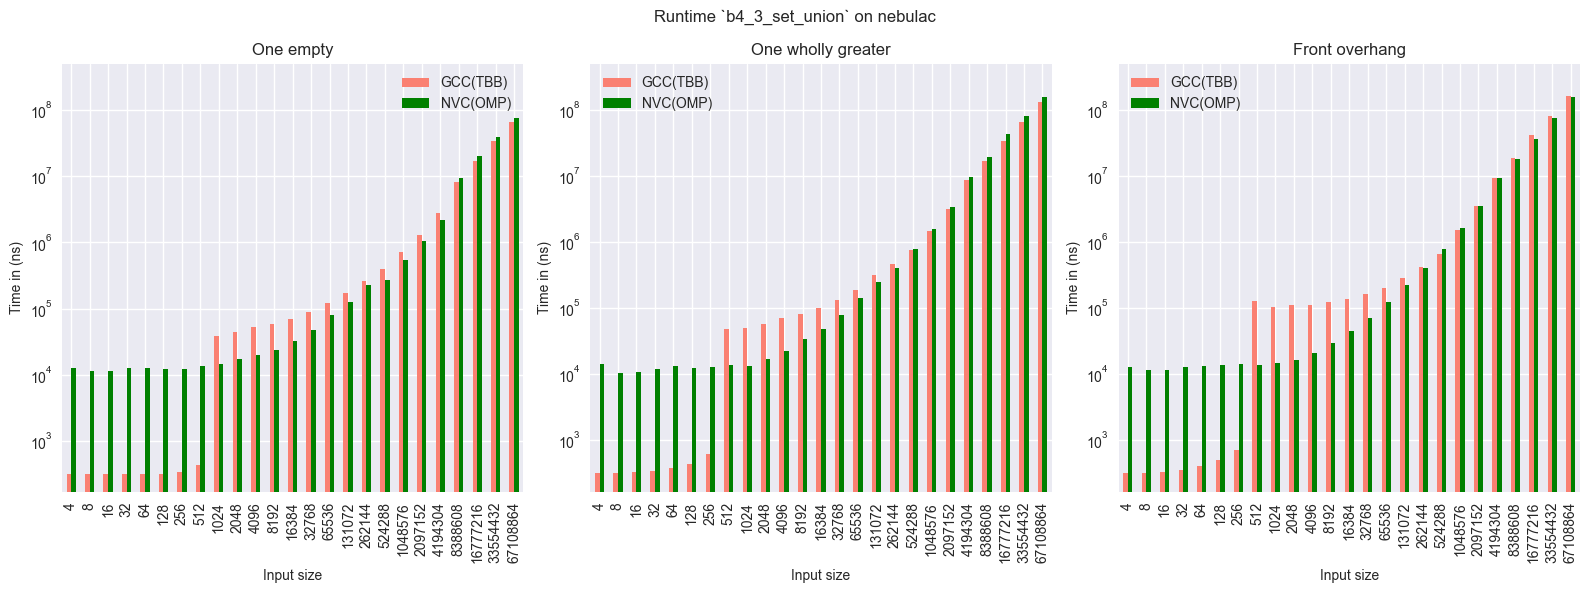

In [237]:
# all set_union graphs

y_lim = 5*pow(10,8)
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])


ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Input size')
ax_1.set_title('One empty')
ax_1.set_ylim(0,y_lim)

# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Input size')
ax_2.set_title('One wholly greater')
ax_2.set_ylim(0,y_lim)


# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Input size')
ax_3.set_title('Front overhang')
ax_3.set_ylim(0,y_lim)

fig.suptitle("Runtime `b4_3_set_union` on nebulac")

fig.tight_layout()

plot("Runtime `b4_3_set_union` on nebulac")

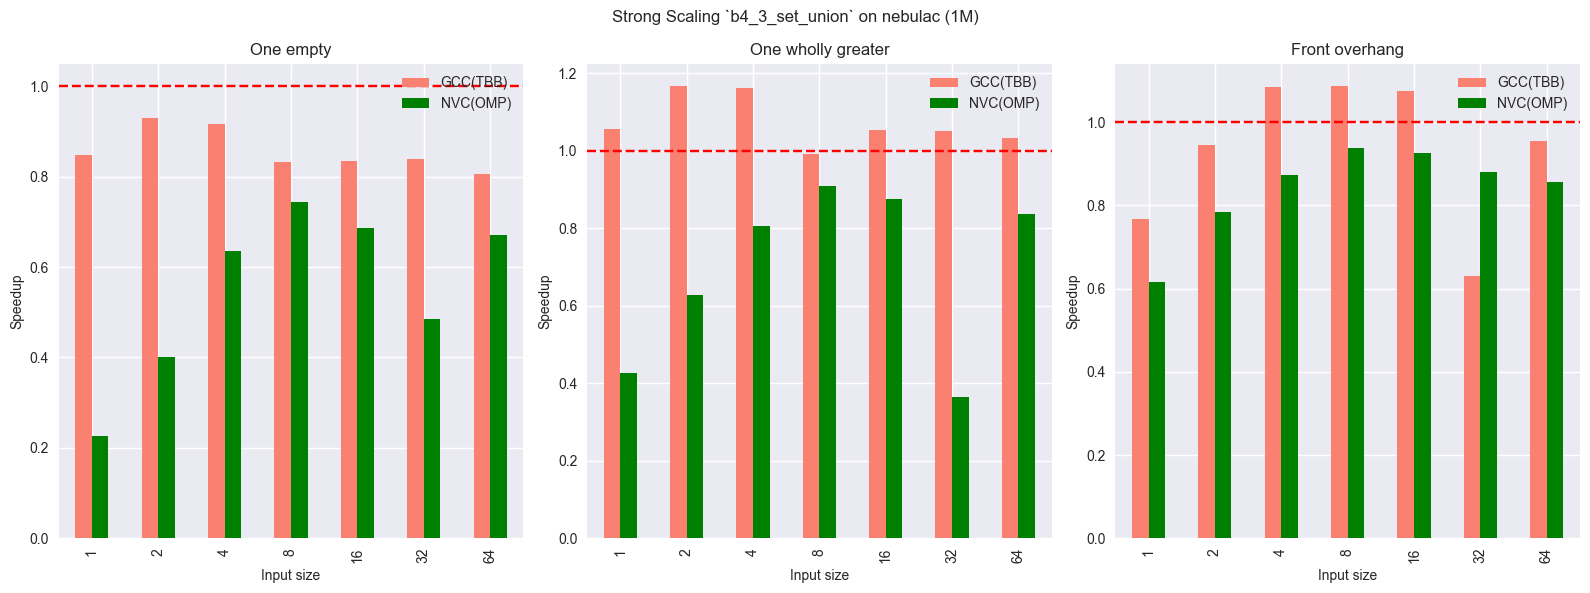

In [219]:
# all set_union graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Input size')
ax_1.set_title('One empty')
ax_1.axhline(y=1, color='r',linestyle='--')
# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Input size')
ax_2.set_title('One wholly greater')
ax_2.axhline(y=1, color='r',linestyle='--')

# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Input size')
ax_3.set_title('Front overhang')
ax_3.axhline(y=1, color='r',linestyle='--')
fig.suptitle("Strong Scaling `b4_3_set_union` on nebulac (1M)")

fig.tight_layout()

plot("Strong Scaling `b4_3_set_union` on nebulac (1M)")

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_79168/3409871832.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_79168/3409871832.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_79168/3409871832.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


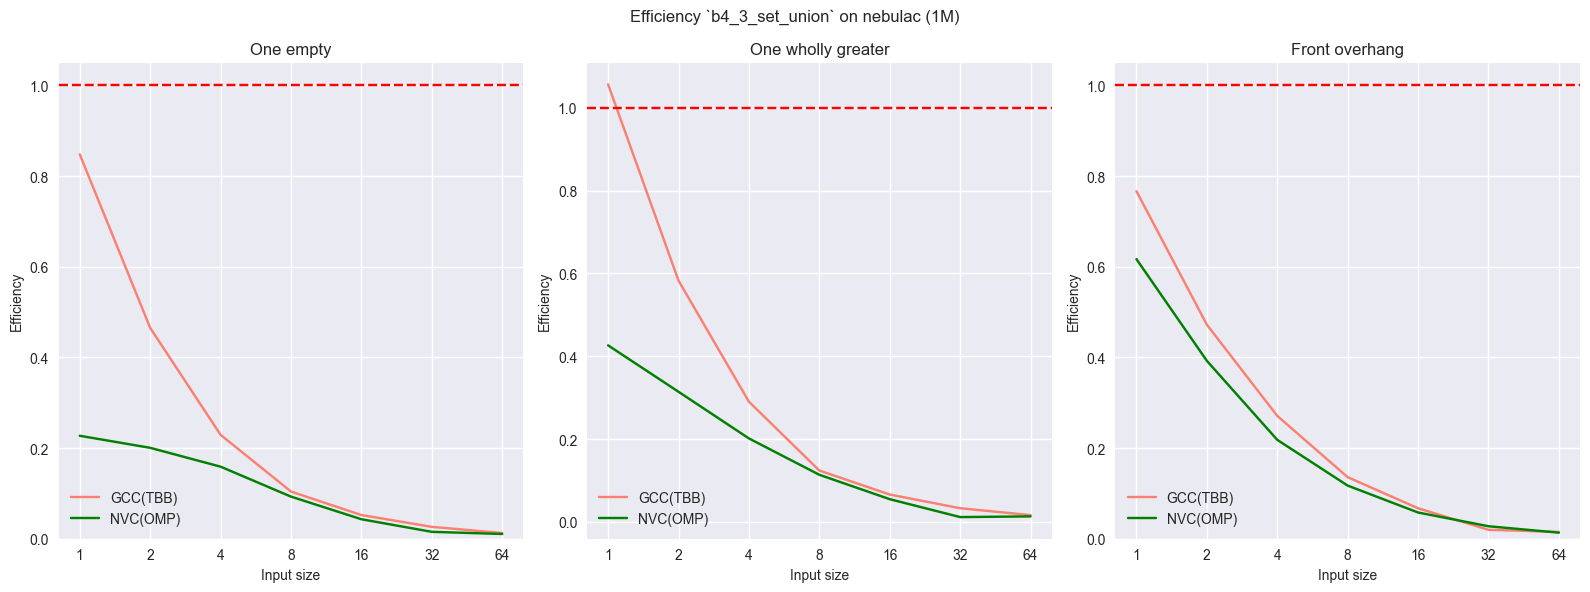

In [238]:
# efficiency  set_union graphs


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Input size')
ax_1.set_title('One empty')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Input size')
ax_2.set_title('One wholly greater')
ax_2.axhline(y=1, color='r',linestyle='--')
#ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Input size')
ax_3.set_title('Front overhang')
ax_3.axhline(y=1, color='r',linestyle='--')
ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


fig.suptitle("Efficiency `b4_3_set_union` on nebulac (1M)")

fig.tight_layout()

plot("Efficiency `b4_3_set_union` on nebulac (1M)")

## `b4_4_set_difference`

### Time Comparison - `b4_4_set_difference_cutoff_left_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [221]:
def b4_4_set_difference_cutoff_left_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_left_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_left_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_left_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_left_empty_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_left_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,271.168,4,274.849
1,271.283,8,274.670
2,272.359,16,274.943
3,272.149,32,274.683
4,271.931,64,274.781
5,272.902,128,274.809
6,271.463,256,274.761
7,272.268,512,274.820
8,272.432,1024,274.722
9,272.011,2048,274.665


### Time Comparison - `b4_4_set_difference_cutoff_right_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [222]:
def b4_4_set_difference_cutoff_right_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_right_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_right_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_right_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_right_empty_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_right_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,6298.44,4,14067.0
1,11566.80,8,11669.4
2,17047.00,16,11390.0
3,21542.20,32,11937.3
4,25001.00,64,12965.4
5,26807.20,128,12485.1
6,29523.70,256,11755.0
7,34074.50,512,12626.0
8,37565.90,1024,14843.3
9,43481.30,2048,17364.3


### Time Comparison - `b4_4_set_difference_cutoff_wholly_greater_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [223]:
def b4_4_set_difference_cutoff_wholly_greater_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_wholly_greater_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_wholly_greater_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_wholly_greater_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_wholly_greater_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_wholly_greater_time_merged

,GCC(TBB),n,NVC(OMP)
0,5543.81,4,3.185250e+02
1,10052.90,8,3.222500e+02
2,15374.80,16,3.245660e+02
3,20646.70,32,3.345890e+02
4,24288.20,64,3.668220e+02
5,25974.30,128,4.268570e+02
6,30394.30,256,5.233440e+02
7,34520.10,512,7.474830e+02
8,37126.30,1024,1.145620e+03
9,43406.60,2048,1.917930e+03


### Time Comparison - `b4_4_set_difference_cutoff_intersected_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [224]:
def b4_4_set_difference_cutoff_intersected_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_intersected_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_intersected_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_intersected_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_intersected_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_intersected_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.132730e+02,4,3.212890e+02
1,3.207430e+02,8,3.244460e+02
2,3.405540e+02,16,3.328440e+02
3,4.018500e+02,32,3.449150e+02
4,4.850220e+02,64,3.846670e+02
5,6.529430e+02,128,4.417650e+02
6,9.848120e+02,256,5.413300e+02
7,1.091230e+05,512,7.698880e+02
8,9.869820e+04,1024,1.170260e+03
9,9.466920e+04,2048,1.937490e+03


### Strong Scaling - `b4_4_set_difference_cutoff_left_empty_par`

1 Million fixed input size with threads 1-64

In [225]:
def get_b4_4_set_difference_cutoff_left_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_left_empty_seq__Default.csv',
                                            COMP=compiler_name)
    
    
    ## b4_4_set_difference_cutoff_left_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_left_empty_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_left_empty_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_left_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_left_empty_strong_scaling_merged


,threads,GCC(TBB),NVC(OMP)
0,1,0.969512,0.940320
1,2,0.984483,0.932224
2,4,0.980389,0.939954
3,8,0.975149,0.929565
4,16,0.974303,0.931126
5,32,0.978321,0.942494
6,64,0.975249,0.940816


In [226]:
# efficiency b4_4_set_difference_cutoff_left_empty_par
b4_4_set_difference_cutoff_left_empty_efficiency = b4_4_set_difference_cutoff_left_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_left_empty_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_left_empty_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_left_empty_efficiency['threads']



b4_4_set_difference_cutoff_left_empty_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,0.969512,0.940320
1,2,0.492242,0.466112
2,4,0.245097,0.234988
3,8,0.121894,0.116196
4,16,0.060894,0.058195
5,32,0.030573,0.029453
6,64,0.015238,0.014700


### Strong Scaling - `b4_4_set_difference_cutoff_right_empty_par`

1 Million fixed input size with threads 1-64

In [227]:
def get_b4_4_set_difference_cutoff_right_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    

    ## seq base
    sq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_right_empty_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## b4_4_set_difference_cutoff_right_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_right_empty_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_right_empty_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_right_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_right_empty_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.850833,0.227329
1,2,0.933395,0.398742
2,4,0.918605,0.633057
3,8,0.800919,0.723752
4,16,0.838858,0.354883
5,32,0.536910,0.709451
6,64,0.426613,0.668284


In [228]:
# efficiency b4_4_set_difference_cutoff_right_empty_par
b4_4_set_difference_cutoff_right_empty_efficiency = b4_4_set_difference_cutoff_right_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_right_empty_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_right_empty_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_right_empty_efficiency['threads']



b4_4_set_difference_cutoff_right_empty_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.850833,0.227329
1,2,0.466698,0.199371
2,4,0.229651,0.158264
3,8,0.100115,0.090469
4,16,0.052429,0.022180
5,32,0.016778,0.022170
6,64,0.006666,0.010442


#### Strong Scaling - `b4_4_set_difference_cutoff_wholly_greater_par`

1 Million fixed input size with threads 1-64

In [229]:
def get_b4_4_set_difference_cutoff_wholly_greater_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_wholly_greater_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## b4_4_set_difference_cutoff_wholly_greater_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_wholly_greater_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_wholly_greater_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.272365,1.004478
1,2,1.401200,1.003803
2,4,1.387705,1.003100
3,8,0.731901,1.004125
4,16,1.258868,1.005559
5,32,1.241526,1.004537
6,64,1.233923,1.004149


In [230]:

# efficiency b4_4_set_difference_cutoff_wholly_greater_par
b4_4_set_difference_cutoff_wholly_greater_efficiency = b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_wholly_greater_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_wholly_greater_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_wholly_greater_efficiency['threads']



b4_4_set_difference_cutoff_wholly_greater_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,1.272365,1.004478
1,2,0.700600,0.501901
2,4,0.346926,0.250775
3,8,0.091488,0.125516
4,16,0.078679,0.062847
5,32,0.038798,0.031392
6,64,0.019280,0.015690


### Strong Scaling - `b4_4_set_difference_cutoff_intersected_par`

1 Million fixed input size with threads 1-64

In [231]:
def get_b4_4_set_difference_cutoff_intersected_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
     ## seq base
    sq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_intersected_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## b4_4_set_difference_cutoff_intersected_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_intersected_par',
                                               [1,2,4,8,16,32,64],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_intersected_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_intersected_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_intersected_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.130073,1.000690
1,2,1.882402,0.999314
2,4,2.799041,1.000259
3,8,3.483647,1.000506
4,16,3.145136,1.000857
5,32,3.363043,1.000781
6,64,3.268281,0.999996


In [232]:
# efficiency b4_4_set_difference_cutoff_intersected_par
b4_4_set_difference_cutoff_intersected_efficiency = b4_4_set_difference_cutoff_intersected_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_intersected_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_intersected_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_intersected_efficiency['threads']



b4_4_set_difference_cutoff_intersected_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,1.130073,1.000690
1,2,0.941201,0.499657
2,4,0.699760,0.250065
3,8,0.435456,0.125063
4,16,0.196571,0.062554
5,32,0.105095,0.031274
6,64,0.051067,0.015625


### Plots

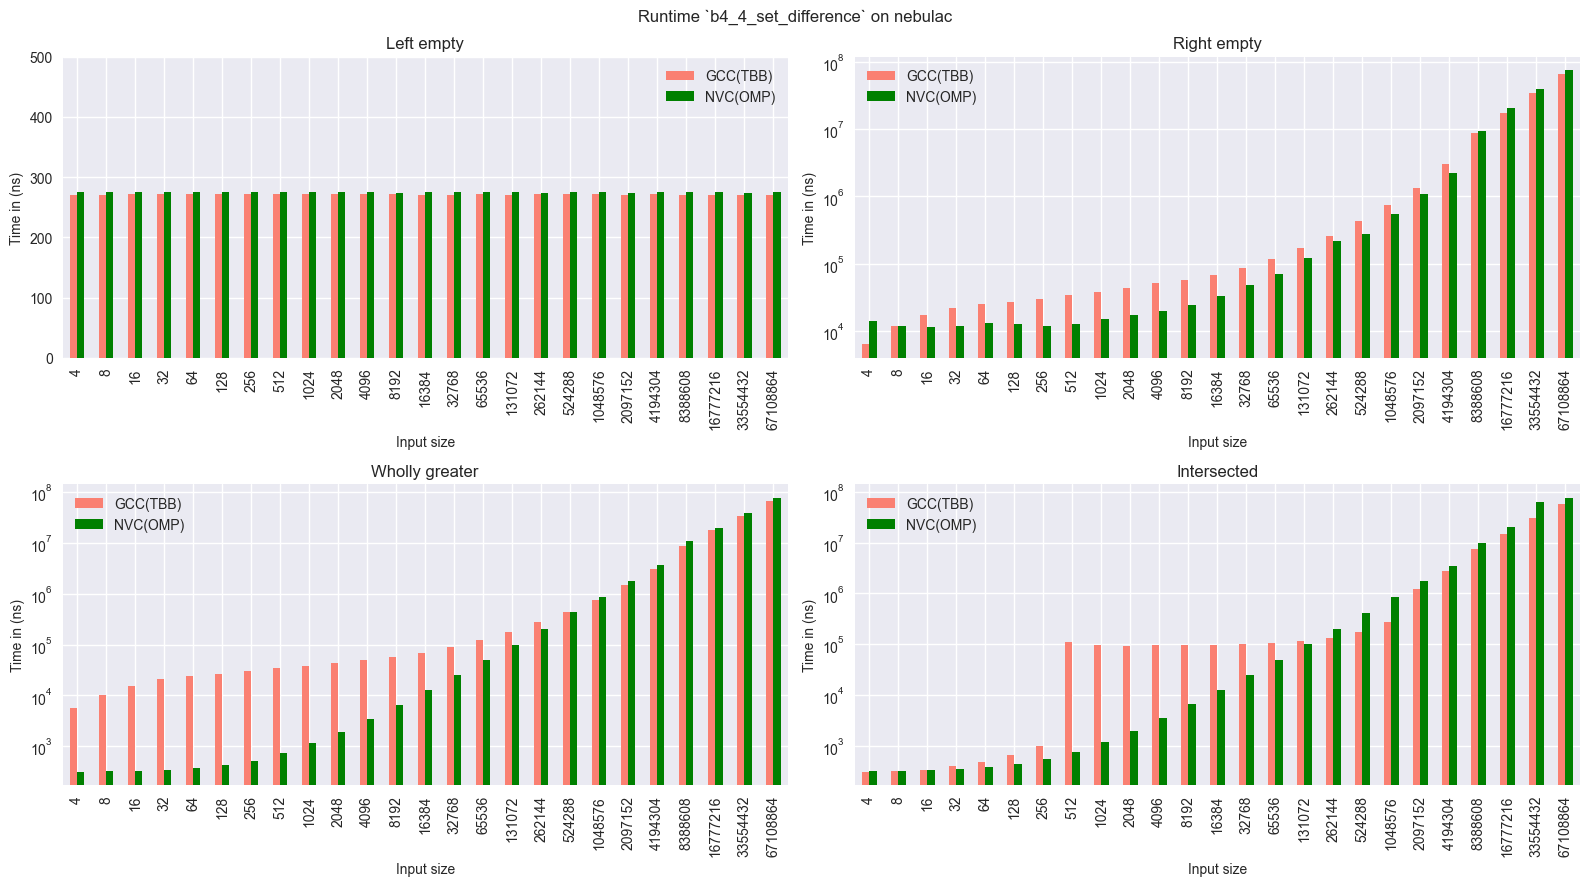

In [233]:
# all set_difference graphs

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Input size')
ax_1.set_title('Left empty')
ax_1.set_ylim(0,500)

# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Input size')
ax_2.set_title('Right empty')


# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Input size')
ax_3.set_title('Wholly greater')


# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_yscale('log', base=10)
ax_4.set_ylabel('Time in (ns)')
ax_4.set_xlabel('Input size')
ax_4.set_title('Intersected')

fig.suptitle("Runtime `b4_4_set_difference` on nebulac")

fig.tight_layout()

plot("Runtime `b4_4_set_difference` on nebulac")

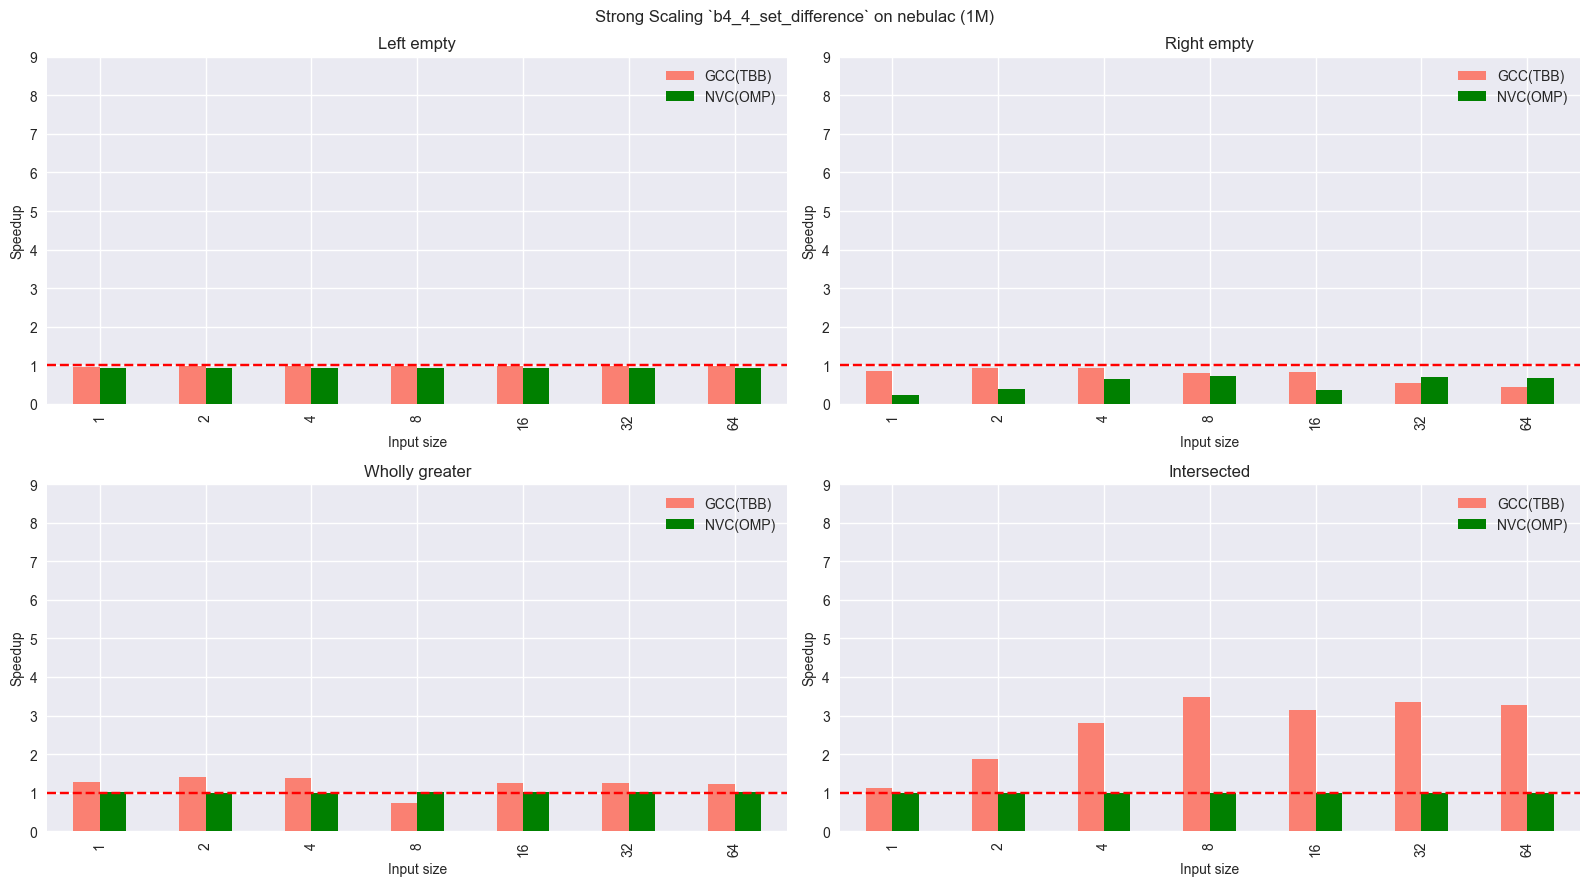

In [239]:
# strong scaling graphs


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Input size')
ax_1.set_title('Left empty')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,9)

# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Input size')
ax_2.set_title('Right empty')
ax_2.axhline(y=1, color='r',linestyle='--')
ax_2.set_ylim(0,9)

# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Input size')
ax_3.set_title('Wholly greater')
ax_3.axhline(y=1, color='r',linestyle='--')
ax_3.set_ylim(0,9)

# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_ylabel('Speedup')
ax_4.set_xlabel('Input size')
ax_4.set_title('Intersected')
ax_4.axhline(y=1, color='r',linestyle='--')
ax_4.set_ylim(0,9)

fig.suptitle("Strong Scaling `b4_4_set_difference` on nebulac (1M)")

fig.tight_layout()

plot("Strong Scaling `b4_4_set_difference` on nebulac (1M)")

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_79168/354110027.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_79168/354110027.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_79168/354110027.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_79168/354110027.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_4.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


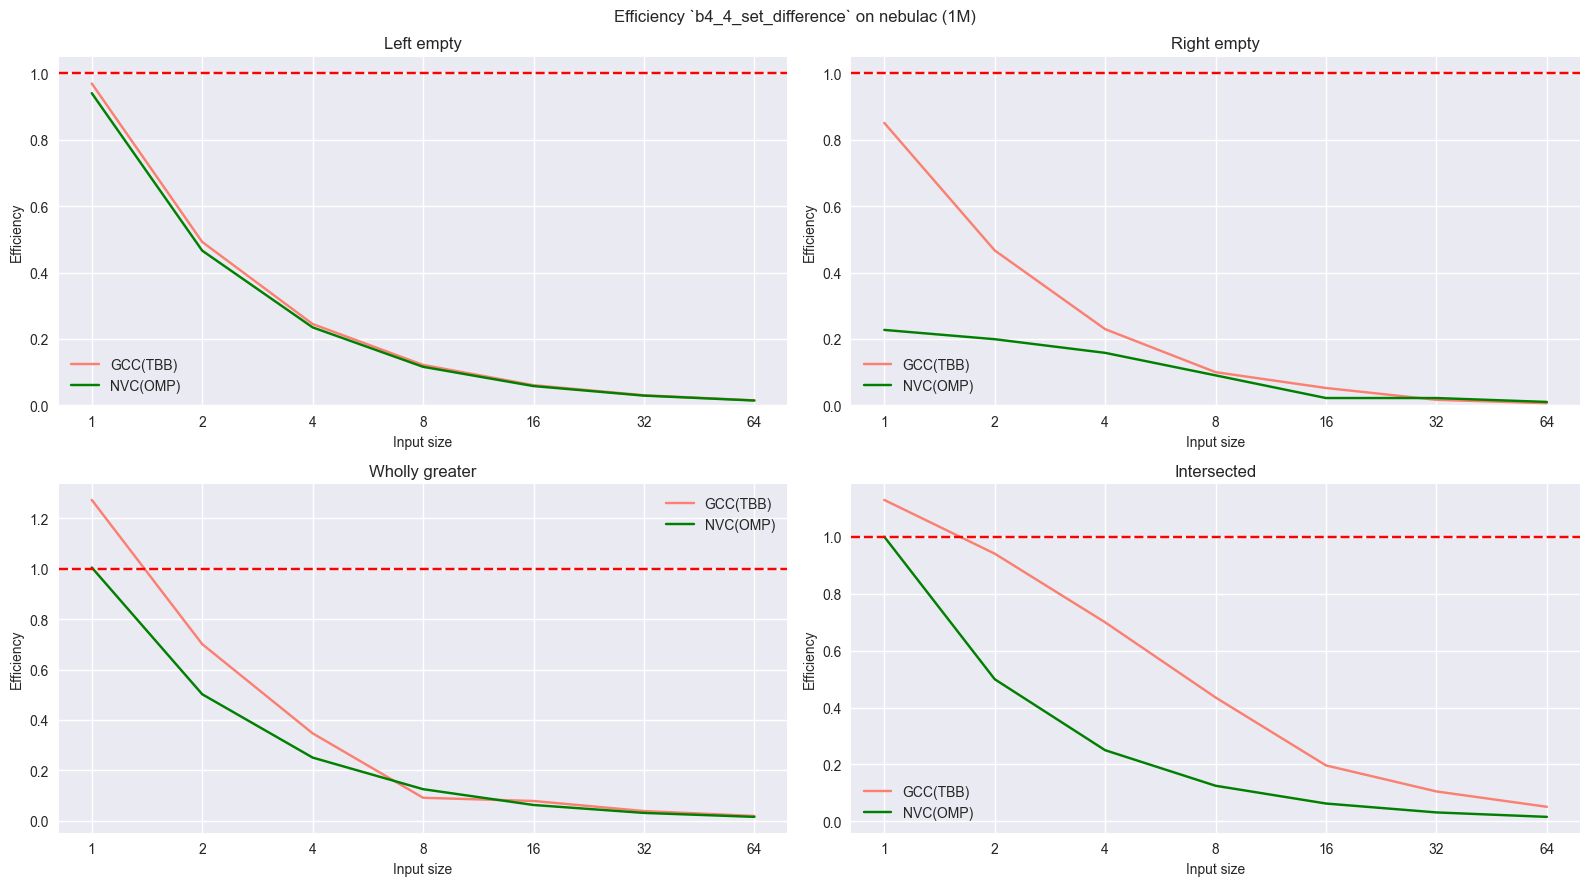

In [242]:
# efficiency graphs


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Input size')
ax_1.set_title('Left empty')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Input size')
ax_2.set_title('Right empty')
ax_2.axhline(y=1, color='r',linestyle='--')
ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Input size')
ax_3.set_title('Wholly greater')
ax_3.axhline(y=1, color='r',linestyle='--')


ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_ylabel('Efficiency')
ax_4.set_xlabel('Input size')
ax_4.set_title('Intersected')
ax_4.axhline(y=1, color='r',linestyle='--')


ax_4.set_xscale('log', base=2)
current_values = ax_4.get_xticks()
ax_4.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])




fig.suptitle("Efficiency `b4_4_set_difference` on nebulac (1M)")

fig.tight_layout()

plot("Efficiency `b4_4_set_difference` on nebulac (1M)")

## Performance Portability Calculation (Inter Compiler)

TODO

## Findings for H4

### Findings `b4_1_merge`



### Findings `b4_2_stable_sort`



### Findings `b4_3_set_union`



### Findings `b4_4_set_difference`



### General



### GPU Findings



### Hypothesis Findings

